In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import tqdm as notebook_tqdm
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [14]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [15]:
train = pd.read_csv('../03_outlier/train_processed.csv')
test  = pd.read_csv('../03_outlier/test_processed.csv')

In [16]:
train.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일-사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60㎡이하_',
       'k_전용면적별세대현황_60㎡~85㎡이하_', 'k_85㎡~135㎡이하', 'k_수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', 'is_test', '주소', '경도', '위도', '1_bus', '3_bus',
       '5_bus', '10_bus', '1_school', '3_school', '5_school', '10_school',
       'bus_access_score', 'sub_access_score', 'school_access_score', '1_sub',
       '3_sub', '5_sub', '10_sub', '계약연도', '계약월', '구', '동', '아파트_최고층',
       '층_최고층대비비율', '층구간_상대', '구_해당달_거래수', '동_해당달_거래수', '구_직전달까지누적거래수',
       '동_직전달까지누적거래수', '동대구_해당달_비율', '동대구_직전누적_비율', '연식', '연식_bin', '강남여부',
       '브랜드', 'area_bin_in_region', 'target_log_clip'],
      dtype='object')

In [17]:
target_col = 'target_log_clip'

In [18]:
# 범주형 컬럼 자동 탐지 + 명시적 범주형 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]

In [19]:
# Train/Test 합쳐 카테고리 정합
if len(cat_cols) > 0:
    concat = pd.concat([train[cat_cols], test[cat_cols]], axis=0, ignore_index=True)
    for c in cat_cols:
        concat[c] = concat[c].astype('category')
    for c in cat_cols:
        train[c] = pd.Categorical(train[c], categories=concat[c].cat.categories)
        test[c]  = pd.Categorical(test[c],  categories=concat[c].cat.categories)

In [20]:
# 피처/타깃 분리 (is_test는 정보량이 없으므로 제거)
drop_cols = [target_col]
if 'is_test' in train.columns:
    drop_cols.append('is_test')

In [21]:
X = train.drop(columns=drop_cols)
y = train[target_col].astype(float)
X_test = test.drop(columns=['is_test']) if 'is_test' in test.columns else test.copy()

In [22]:
categorical_feature = cat_cols
print(f"[INFO] 사용 범주형 컬럼: {categorical_feature}")
print(f"[INFO] X.shape={X.shape}, X_test.shape={X_test.shape}")

[INFO] 사용 범주형 컬럼: ['k_세대타입_분양형태_', '주소', '층구간_상대', 'k_수정일자', '동', 'k_팩스번호', '브랜드', 'k_단지분류_아파트_주상복합등등_', 'k_사용검사일-사용승인일', 'k_시행사', '연식_bin', '경비비관리형태', 'k_복도유형', '도로명', 'k_전화번호', '아파트명', '청소비관리형태', 'k_관리방식', 'area_bin_in_region', '세대전기계약방법', '구', 'k_난방방식', 'k_건설사_시공사_']
[INFO] X.shape=(107534, 67), X_test.shape=(9272, 67)


In [23]:
# K-Fold 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

# 베스트 폴드 단일 모델만 선택
best_model = None
best_fold = None
best_fold_rmse = np.inf
best_iteration = None

# 충분히 큰 반복 + Early Stopping
base_params = dict(
    random_state=2023,
    n_estimators=100000
)

oof_pred_log = np.zeros(len(X))
fold_rmses = []

In [24]:
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    print(f"[KFold] Fold {fold}/{n_splits} 학습 중...")
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(**base_params)
    model.fit(
        X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    val_pred_log = model.predict(X_val, num_iteration=model.best_iteration_)
    oof_pred_log[val_idx] = val_pred_log

    # 원스케일 RMSE
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
    fold_rmses.append(rmse)
    print(f"[KFold] Fold {fold} RMSE(orig) = {rmse:,.5f}, best_iter = {model.best_iteration_}")

    # 베스트 폴드 갱신
    if rmse < best_fold_rmse:
        best_fold_rmse = rmse
        best_fold = fold
        best_model = model
        best_iteration = model.best_iteration_

[KFold] Fold 1/5 학습 중...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21815
[LightGBM] [Info] Number of data points in the train set: 86027, number of used features: 67
[LightGBM] [Info] Start training from score 10.906318
[KFold] Fold 1 RMSE(orig) = 6,654.85081, best_iter = 2393
[KFold] Fold 2/5 학습 중...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto

In [29]:
# 교차검증 요약
print(f"[KFold] CV RMSE(orig): mean={np.mean(fold_rmses):,.5f}, std={np.std(fold_rmses):,.5f}")
print(f"[KFold] Best fold = {best_fold}, RMSE(orig) = {best_fold_rmse:,.5f}, best_iter = {best_iteration}")

# 테스트 예측: 베스트 폴드 단일 모델만 사용
preds_best_log = best_model.predict(X_test, num_iteration=best_iteration)
preds_best = np.expm1(preds_best_log).astype(np.int64)

[KFold] CV RMSE(orig): mean=6,374.32006, std=149.88694
[KFold] Best fold = 3, RMSE(orig) = 6,222.74908, best_iter = 2295


In [26]:
# 저장
sub_path = 'lgbm_kfold_basic_bestfold.csv'
pd.DataFrame({'target': preds_best}).to_csv(sub_path, index=False)
print(f"[SAVE] {sub_path} 저장 완료")

[SAVE] lgbm_kfold_basic_bestfold.csv 저장 완료


In [27]:
preds_best

array([158649, 190616, 245660, ...,  63172,  51938,  52267], shape=(9272,))

Matplotlib is building the font cache; this may take a moment.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


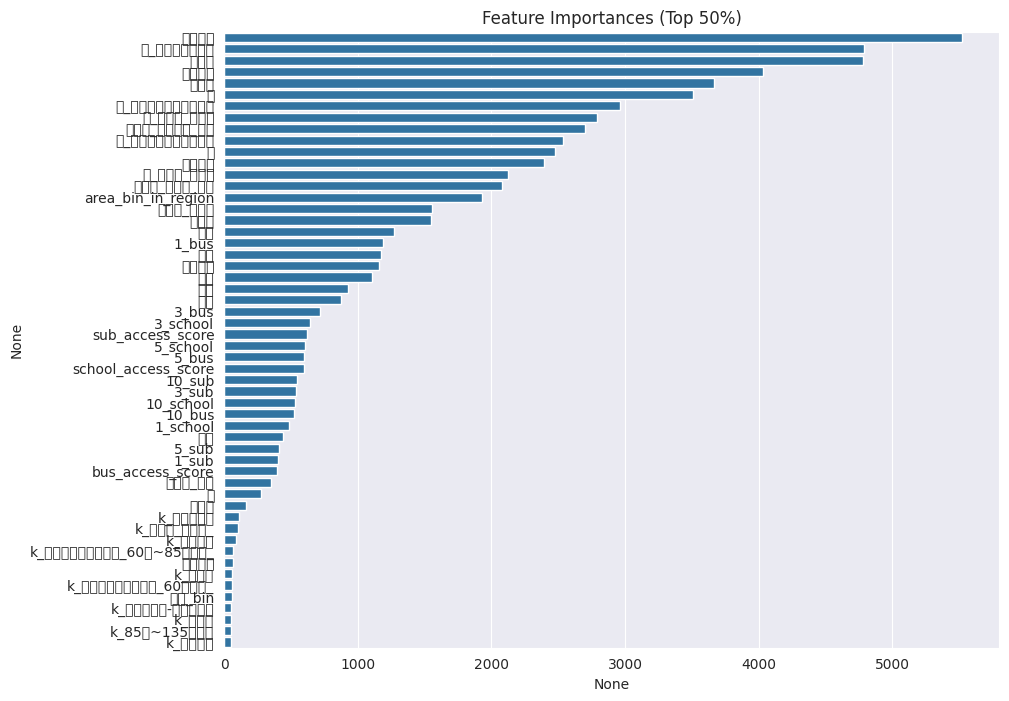

In [28]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X.columns))
importances = importances.sort_values(ascending=False)

# 상위 50%만 선택
top_n = max(1, int(np.ceil(len(importances) * 0.8)))
importances = importances.iloc[:top_n]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Top 50%)")
sns.barplot(x=importances, y=importances.index)
plt.show()